# Analyzing and modifying a reduced basis after assembly

When solving parametrized eigenvalue problems using RB surrogates, the important question
arises, to what degree the surrogate actually reflects the behavior of the original
problem. In particular, one needs to know if the online measurements of observables
contain inaccuracies or unphysical artifacts that stem from a inadequate surrogate. One
possibility to evaluate the surrogate quality is the direct comparison of observables
and vectors obtained from the RB and truth solver. This, however, is a numerically
demanding approach which we will not cover here. So in this example we instead want to
showcase some of the tools that can be used to analyze and correct an assembled basis in
the online stage and in a computationally cheap way.

Before going into the specifics, we first setup an example for which we use the XXZ chain
where the snapshots are obtained using DMRG (see
Greedy basis assembly using DMRG).

In [1]:
using LinearAlgebra
using ITensors
using ReducedBasis
using Random: seed!
seed!(0)  # Seed to make example consistent

function xxz_chain(sites::IndexSet; kwargs...)
    xy_term   = OpSum()
    zz_term   = OpSum()
    magn_term = OpSum()
    for i in 1:(length(sites) - 1)
        xy_term   += "Sx", i, "Sx", i + 1
        xy_term   += "Sy", i, "Sy", i + 1
        zz_term   += "Sz", i, "Sz", i + 1
        magn_term += "Sz", i
    end
    magn_term += "Sz", length(sites)  # Add last magnetization term
    coefficients = μ -> [1.0, μ[1], -μ[2]]
    AffineDecomposition([ApproxMPO(MPO(xy_term, sites), xy_term; kwargs...),
                         ApproxMPO(MPO(zz_term, sites), zz_term; kwargs...),
                         ApproxMPO(MPO(magn_term, sites), magn_term; kwargs...)],
                        coefficients)
end

L = 12
sites = siteinds("S=1/2", L)
H = xxz_chain(sites; cutoff=1e-9)
dm = DMRG()
Δ = range(-1.0, 2.5; length=40)
hJ = range(0.0, 3.5; length=40)
grid_train = RegularGrid(Δ, hJ);

Up to this points we chose reasonable parameters for the basis assembly. However, we now
intend to generate a bad surrogate with purposefully bad settings.

!!! warning "Bad settings"
    The offline settings that are chosen here and also later in the example are
    intentionally chosen to produce unconverged (and thus wrong) results, i.e., the
    "side effects" observed in this example should not happen in real applications and
    would indicate inappropriate parameters.

Namely, we limit our basis size to `n_truth_max=6` truth solves and use a compression
cutoff of `cutoff=1e-10` which is lower than the energy and singular value cutoff above:

In [2]:
greedy = Greedy(; estimator=Residual(), n_truth_max=8)
edcomp = EigenDecomposition(; cutoff=0.0);

We therefore let unphysical modes eventually enter our basis. The first useful object
that we encounter is the `InfoCollector` that can be used to collect various
quantities that are computed in each greedy iteration. We chain the collector together
with the `print_callback` via the `∘` operator and use the resulting function
as the callback function during assembly:

In [3]:
collector = InfoCollector(:basis, :h_cache)
rbres = assemble(H, grid_train, greedy, dm, edcomp;
                 callback=collector ∘ print_callback);

n      max. err    ‖BᵀB-I‖     time      μ       
------------------------------------------------------------
1      NaN         6.66e-16     1.23s    [-1.0, 0.0]
2      6.3         3.51e-16     1.78s    [2.5, 3.5]
3      3.36        6.27e-16     929ms    [2.5, 0.538]
4      1.52        1.05e-14     1.37s    [-0.282, 0.09]
5      1.87        1.01e-13     620ms    [2.5, 2.513]
6      0.934       2e-15        649ms    [0.795, 0.0]
7      0.726       5.68e-15     606ms    [0.077, 0.718]
8      0.868       6.73e-15     595ms    [2.5, 3.141]


Using this presumably inaccurate surrogate, we compute the magnetization

In [4]:
M = AffineDecomposition([H.terms[3]], [2 / L])
m, _ = compress(M, rbres.basis)
m_reduced = m();

on a finer online grid using the matching online solver

In [5]:
Δ_online    = range(first(Δ), last(Δ); length=100)
hJ_online   = range(first(hJ), last(hJ); length=100)
grid_online = RegularGrid(Δ_online, hJ_online)
fulldiag    = FullDiagonalization(dm);

and additionally save all computed RB coefficients for later analysis:

In [6]:
using Statistics
rbcoeff = similar(grid_online, Matrix{ComplexF64})
magnetization = similar(grid_online, Float64)
for (idx, μ) in pairs(grid_online)
    _, φ_rb = solve(rbres.h, rbres.basis.metric, μ, fulldiag)
    rbcoeff[idx] = φ_rb
    magnetization[idx] = mean(u -> abs(dot(u, m_reduced, u)), eachcol(φ_rb))
end

We then end up with a magnetization heatmap that significantly deviates from the correct
phase diagram (compare e.g. with Greedy basis assembly using DMRG):

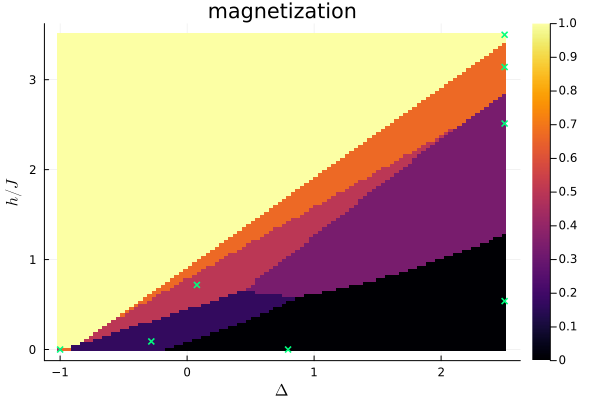

In [7]:
using Plots
xrange, yrange = grid_online.ranges[1], grid_online.ranges[2]
params = unique(rbres.basis.parameters)
xpoints, ypoints = [μ[1] for μ in params], [μ[2] for μ in params]
hm_kwargs = (; xlabel=raw"$\Delta$", ylabel=raw"$h/J$", colorbar=true, leg=false)
marker_kwargs = (; markershape=:xcross, mcolor=:springgreen, ms=3.0, msw=2.0);

hm = heatmap(xrange, yrange, magnetization';
             clims=(0.0, 1.0), title="magnetization", hm_kwargs...)
scatter!(hm, xpoints, ypoints; marker_kwargs...)

So what happened here (on purpose) is that the RB does not contain enough
snapshots to fully resolve all features of the true phase diagram. To further dissect
the problems, let us look at some of the possible ways to analyze the basis, based on
the quantities we already have at our disposal.

## Online diagnostics

To visualize the degree to which the different snapshot vectors are "mixed" using the online
RB coefficients, we can compute the so-called *participation ratio*

$$
\mathrm{PR}(\phi) = \frac{1}{d} \frac{1}{\sum_{k=1}^d |\phi_k|^4}
$$

where we assume the transformed RB vector $\phi(\bm{\mu}) = V \varphi(\bm{\mu})$ to be
normalized. (Here, $V$ corresponds to the orthonormalizing matrix that is contained in
`RBasis`.) For maximally mixing RB coefficients with $\phi_k = 1/\sqrt{d}$ the
participation ratio becomes maximal at $\mathrm{PR}=1$, whereas a unit vector produces
the minimal participation ratio of $\mathrm{PR}=1/d$. The RB coefficients from before
produce the following $\mathrm{PR}$:

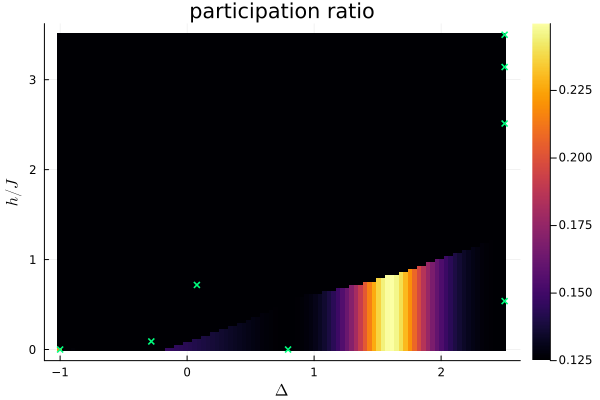

In [8]:
d = dimension(rbres.basis)
pr = map(rbcoeff) do φ
    ϕ = rbres.basis.vectors * φ
    1 / (d * sum(x -> abs2(x)^2, ϕ / norm(ϕ)))
end

hm = heatmap(xrange, yrange, pr'; title="participation ratio", hm_kwargs...)
scatter!(hm, xpoints, ypoints; marker_kwargs...)

Most magnetization plateaus are spanned by merely one snapshot (low $\mathrm{PR}$),
whereas multiple snapshots within one plateau lead to a mixing of RB coefficients.
Another way to look at the RB coefficients is to find the maximal coefficient of each
$\phi$ vector on the online grid and then assign it a color. The resulting heatmap
displays Voronoi-like cells around the snapshot parameter points. Using the collected
info contained in the `collector`, we can even animate these cells with respect to the
greedy iterations:

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket application

GKS: Open failed in routine OPEN_WS
GKS: GKS not in proper state. GKS must be either in the state WSOP or WSAC in routine ACTIVATE_WS
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: linuxfb, minimal, offscreen, vnc, xcb.

Aborted (core dumped)
connect: Connection refused
GKS: can't connect to GKS socket app

Plots.AnimatedGif("/tmp/jl_CNu10D6xsD.gif")
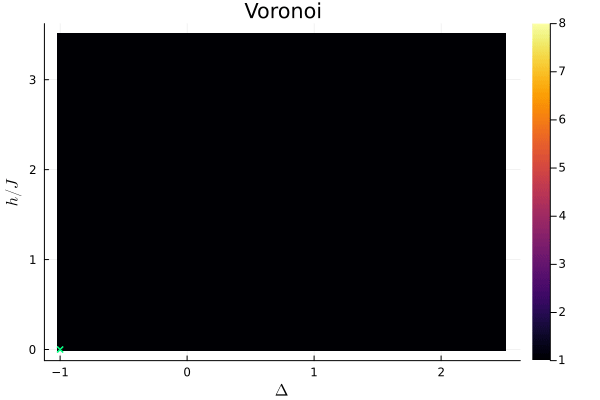

In [9]:
anim = @animate for n in 1:dimension(rbres.basis)
    data = collector.data
    ϕ = map(grid_online) do μ
        _, φ = solve(data[:h_cache][n].h, data[:basis][n].metric, μ, fulldiag)
        data[:basis][n].vectors * φ
    end
    voronoi = map(φ -> findmax(abs.(@view φ[:, 1]))[2], ϕ)
    hm = heatmap(xrange, yrange, voronoi';
                 title="Voronoi", clims=(1, 8), hm_kwargs...)
    p = unique(data[:basis][n].parameters)
    scatter!(hm, [μ[1] for μ in p], [μ[2] for μ in p]; marker_kwargs...)
end
gif(anim; fps=0.7)

We see that with each new snapshot we map out a new domain of the parameter space.
Hence to further resolve the phase diagram, we will need to add more snapshots.

## Continuing an assembly

To continue assembling a basis, we can just call `assemble` and provide
the `rbres` tuple from the previous greedy assembly. Of course the remaining arguments
can be adjusted in the continued assembly, so let us now increase the maximal number of
truth solves:

In [10]:
greedy_cont = Greedy(; estimator=Residual(), n_truth_max=36)
rbres_cont = assemble(rbres, H, grid_train, greedy_cont, dm, edcomp);

n      max. err    ‖BᵀB-I‖     time      μ       
------------------------------------------------------------
9      0.723       8.93e-15     651ms    [0.795, 0.538]
10     0.814       1.48e-14     757ms    [2.5, 0.897]
11     0.708       2.88e-14     660ms    [2.051, 2.423]
12     0.538       2.38e-13     718ms    [0.705, 0.897]
13     0.443       1.79e-14     893ms    [-0.103, 0.0]
14     0.274       5.09e-14     908ms    [-0.372, 0.269]
15     0.233       6.72e-14     2.10s    [-0.91, 0.0]
16     0.229       7.29e-14     947ms    [-0.462, 0.449]
17     0.113       1.34e-13     941ms    [-0.641, 0.09]
18     0.103       9.22e-14     2.86s    [-0.821, 0.09]
19     0.079       1.16e-12     1.36s    [1.782, 0.359]
20     0.0748      1.07e-12     1.15s    [-0.731, 0.09]
21     0.041       8.56e-12     1.23s    [1.692, 1.256]
22     0.0393      5.96e-12     1.31s    [-0.641, 0.0]
23     0.0269      3.99e-12     1.34s    [0.526, 1.436]
24     0.0933      6.63e-12     1.37s    [2.5, 3.41]


Apparently, the assembly was stopped since an already solved snapshot was about to be
solved again — which cannot happen in a correctly assembled greedy basis, indicating that
the online evaluations of observables will contain artifacts. So let us check that by
recomputing the magnetization using the continued basis:

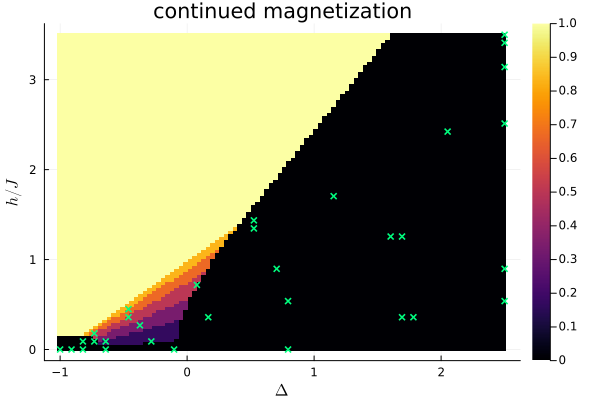

In [11]:
m_cont, m_cont_raw = compress(M, rbres_cont.basis)
m_reduced_cont = m_cont()

magn_cont = map(grid_online) do μ
    _, φ_rb = solve(rbres_cont.h_cache.h, rbres_cont.basis.metric, μ, fulldiag)
    mean(u -> abs(dot(u, m_reduced_cont, u)), eachcol(φ_rb))
end
hm = heatmap(xrange, yrange, magn_cont';
             clims=(0.0, 1.0), title="continued magnetization", hm_kwargs...)
params = unique(rbres_cont.basis.parameters)
scatter!(hm, [μ[1] for μ in params], [μ[2] for μ in params]; marker_kwargs...)

Indeed, the magnetization heatmap seems to be broken (again compare with
Greedy basis assembly using DMRG); the phase diagram contains a large artifact
related to the $M=0$ plateau. In these cases, we need to fix the RB by removing
snapshots from it.

## Truncation of snapshots

Fortunately, the greedy assembly is reversible without significant computational effort,
meaning we can `truncate` our `RBasis` to a desired number of truth
solves. Let us remove the last few snapshots to correct the error incurred by repeated
MPS approximations:

In [12]:
basis_trunc = truncate(rbres_cont.basis, 30);

Since we performed multiple compressions using the previous `rbres_cont.basis`, we also
need to truncate the `HamiltonianCache` according to the truncated basis:

In [13]:
h_cache_trunc = truncate(rbres_cont.h_cache, basis_trunc);

A slightly more subtle thing occurs with the compressed `AffineDecomposition`s.
Here we need to provide the second return argument `m_cont_raw` of the compressed magnetization
from above, since only the untransformed compressed magnetization can be truncated accordingly:

In [14]:
m_trunc = truncate(m_cont_raw, basis_trunc)
m_reduced_trunc = m_trunc();

Finally, let us recompute the magnetization but this time with the truncated
quantities and check the heatmap plot:

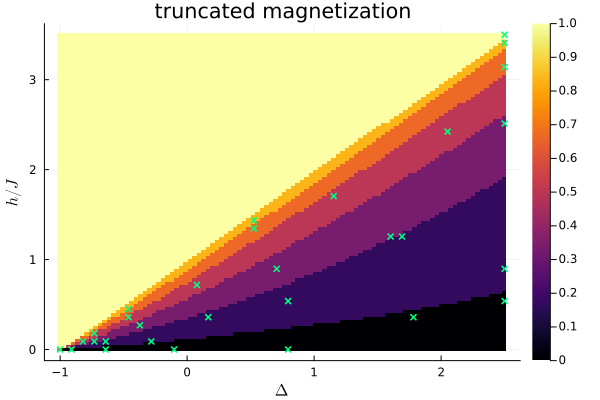

In [15]:
magn_trunc = map(grid_online) do μ
    _, φ_rb = solve(h_cache_trunc.h, basis_trunc.metric, μ, fulldiag)
    mean(u -> abs(dot(u, m_reduced_trunc, u)), eachcol(φ_rb))
end
hm = heatmap(xrange, yrange, magn_trunc';
             clims=(0.0, 1.0), title="truncated magnetization", hm_kwargs...)
params = unique(basis_trunc.parameters)
scatter!(hm, [μ[1] for μ in params], [μ[2] for μ in params]; marker_kwargs...)

By truncating the basis and all compressed quantities, we have recovered the correct phase
diagram. This process did not involve any computationally expensive operations and can
therefore be always performed as a consistency check on a generated basis.